# HomeWork #4 -Sentiment analysis (ECS 189L)
##### ANIRUDH RAMCHANDRAN

- import libraries necessary 

In [1]:
import pandas as pd 
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import numpy as np

warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import itertools
import collections
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- reading the data and storing into data frame 

In [2]:
df_ori=pd.read_csv('https://raw.githubusercontent.com/lkyin/ECS189L/main/Tweets.csv')
df=df_ori.copy()

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df.shape

(14640, 15)

##  Data Cleaning 

- checking the percentage of missing values

In [5]:
Nan_values=df.isna().sum().sort_values(ascending=False)*100/len(df)
Nan_values

negativereason_gold             99.781421
airline_sentiment_gold          99.726776
tweet_coord                     93.039617
negativereason                  37.308743
user_timezone                   32.923497
tweet_location                  32.329235
negativereason_confidence       28.128415
tweet_created                    0.000000
text                             0.000000
retweet_count                    0.000000
name                             0.000000
airline                          0.000000
airline_sentiment_confidence     0.000000
airline_sentiment                0.000000
tweet_id                         0.000000
dtype: float64

- we see that the columns ,negativereason_gold, airlines_sentiment_gold,tweet_coord have over 99% Nan values so we are omitting them                      

In [6]:
df=df.drop(columns=['negativereason_gold','airline_sentiment_gold','tweet_coord'])

# EDA

- First we can wee how many unique airlines are there 

In [7]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

- Then lets look at how many sentiments exists per airline

In [8]:
df.groupby('airline')['airline_sentiment'].count().sort_values()

airline
Virgin America     504
Delta             2222
Southwest         2420
American          2759
US Airways        2913
United            3822
Name: airline_sentiment, dtype: int64

In [9]:
df.groupby('airline')['airline_sentiment'].value_counts()

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: airline_sentiment, dtype: int64

- from the analysis we can understand that United has the most negative tweets
- Southwest has the most positive tweets 
-Virgin America has all types of tweets at quite a simlar rate 

- Next lets look at the reasons for negative tweets 

In [10]:
df_r=df[df['airline_sentiment']=='negative']

In [11]:
y=df_r['negativereason'].value_counts()
y

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [12]:
x=['Customer Service Issue',         
'Late Flight' ,                  
'Cant Tell',                   
'Cancelled Flight',               
'Lost Luggage',                    
'Bad Flight',                      
'Flight Booking Problems',         
'Flight Attendant Complaints',   
'longlines',                     
'Damaged Luggage']                  

[Text(0, 0, 'Customer Service Issue'),
 Text(0, 0, 'Late Flight'),
 Text(0, 0, 'Cant Tell'),
 Text(0, 0, 'Cancelled Flight'),
 Text(0, 0, 'Lost Luggage'),
 Text(0, 0, 'Bad Flight'),
 Text(0, 0, 'Flight Booking Problems'),
 Text(0, 0, 'Flight Attendant Complaints'),
 Text(0, 0, 'longlines'),
 Text(0, 0, 'Damaged Luggage')]

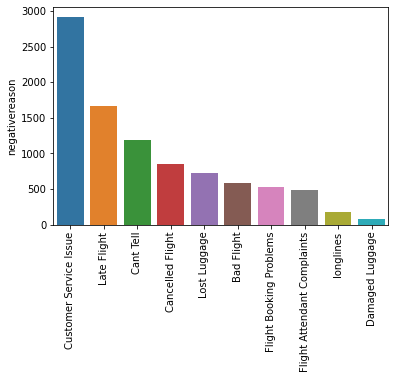

In [13]:
y=df_r['negativereason'].value_counts()
# x=df_r['negativereason'].unique()
plt=sns.barplot(x,y)
plt.set_xticklabels(x,rotation=90)

- As we can see Customer service issue is the major reason for negative tweets for all airlines

# Part #1 

- For this function and the next function get_cleaned (in modelling part) I used the following resources linked below, for reference and ideas to help cleaning the data

- https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
- https://stackoverflow.com/questions/33094164/regular-expression-remove-words-within-string-python
- https://stackoverflow.com/questions/1546226/is-there-a-simple-way-to-remove-multiple-spaces-in-a-string
- https://www.w3resource.com/python-exercises/re/python-re-exercise-39.php
- https://stackoverflow.com/questions/6067592/regular-expression-to-match-only-alphabetic-characters/6067606

In [14]:
def get_frequency(df):
  # first getting the right column from the input data frame 
  text_data = df.iloc[:, 8].values
  clean_words=[]
  n=len(text_data)
  # initial cleaning 
  for word in text_data:
      f=word
      #  since we need it in the form of a list
      f=str(f)
      # to mentions
      c=re.sub(pattern=r'@\w+', repl='',string=f)
      # remove urls
      c=re.sub(pattern=r'http\S+',repl='', string=c)
      #  to remove all special characters 
      c = re.sub(pattern=r'\W', repl=' ', string=c)


      clean_words.append(c)
  # next round of cleaning 
  t=clean_words
  new_cleaned_words=[]
  for word in t:
      f=word
      #  since we need it in the form of a list
      f=str(f)
      # keeping only alphabets
      c = re.sub(pattern='[^a-zA-Z]', repl=' ',string=f)
      # removing multiple spaces
      c = re.sub(pattern=r'\^[a-zA-Z]\s+', repl=' ',string=c)
      c = re.sub(pattern=r'\s\s+', repl=' ',string=c,flags=re.I)
      new_cleaned_words.append(c.lower())    

  # removing stop words 
  new_words=[]
  for word in new_cleaned_words:
    example_sent=word
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(example_sent)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    for i in filtered_sentence:
      new_words.append(i) 
   
  # # trying to count and create a data frame for displaying 
  # # first we create one single iteration using itertools.chain
  words_iter=itertools.chain(new_words)
  #  then we make it in the form of a list
  word_list=list(words_iter)


  # # create a counter of all the words in the form of a dictionary 
  word_counts = collections.Counter(word_list)
  # # now we need to store it into a data frame to display , so that it looks more presentable
  #  removing the most common words using most_common() of Counter 
  common=word_counts.most_common(10) 
  df_words=pd.DataFrame(common, columns=['Words','Count/Frequency'])
  # #  we return the top 10 words 
  return df_words.head(10) 
  # return word_list

### top 10 most frequently used words for negative sentiment 

In [15]:
df_negg=df[df['airline_sentiment']=='negative']
get_frequency(df_negg)

,Words,Count/Frequency
0,flight,2959
1,get,990
2,cancelled,926
3,service,750
4,hours,659
5,help,619
6,hold,614
7,customer,614
8,time,599
9,plane,532


### top 10 most frequently used words for positive sentiment 

In [16]:
df_pos=df[df['airline_sentiment']=='positive']
get_frequency(df_pos)

,Words,Count/Frequency
0,thanks,611
1,thank,455
2,flight,382
3,great,236
4,service,162
5,love,135
6,customer,114
7,get,114
8,guys,110
9,good,109


### top 10 most frequently used words for neutral sentiment 

In [17]:
df_neu=df[df['airline_sentiment']=='neutral']
get_frequency(df_neu)

,Words,Count/Frequency
0,flight,617
1,get,238
2,please,182
3,help,170
4,flights,169
5,need,164
6,thanks,157
7,dm,132
8,would,123
9,us,112


# Part 2 Modelling 

- getting the labels and the text data for modelling and processing 

In [18]:
text_data = df.iloc[:, 8].values
labels = df.iloc[:, 1].values

- this function is simlar to the previous function get_frequency 
- it helps in cleaning the tweet text

In [19]:
def get_cleaned(df):

  clean_words=[]
  n=len(text_data)
  # 
  for word in text_data:
      f=word
      #  since we need it in the form of a list
      f=str(f)
      # to mentions
      c=re.sub(pattern=r'@\w+', repl='',string=f)
      # remove urls
      c=re.sub(pattern=r'http\S+',repl='', string=c)
      #  to remove all special characters 
      c = re.sub(pattern=r'\W', repl=' ', string=c)


      clean_words.append(c)
  # 
  t=clean_words
  new_cleaned_words=[]
  for word in t:
      f=word
      #  since we need it in the form of a list
      f=str(f)
      # keeping only alphabets
      c = re.sub(pattern='[^a-zA-Z]', repl=' ',string=f)
      # removing multiple spaces
      c = re.sub(pattern=r'\^[a-zA-Z]\s+', repl=' ',string=c)
      c = re.sub(pattern=r'\s\s+', repl=' ',string=c,flags=re.I)
      new_cleaned_words.append(c.lower())
  return new_cleaned_words

In [20]:
# get the cleaned data using the function defined previously 
data=get_cleaned(text_data) 

- Since i did not remove stop words before I am removing it while vetorizing 

In [21]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
vectorized_features = vectorizer.fit_transform(data)
new_feat=vectorized_features.toarray()

- Now we once we get vectorized features , we split it into train test split , and we divide it into 80% train and 20% test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(new_feat, labels, test_size=0.2, random_state=0)

- I have used Naive Bayes classifier model 

In [23]:
model_nb= MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)

In [24]:
model_nb.score(X_train, y_train) # score on training data

0.7391564207650273

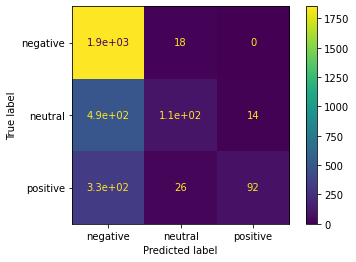

In [25]:
plot_confusion_matrix(model_nb, X_test, y_test) 
# plt.show() 

In [26]:
print('Classificaation Report is:')
print(classification_report(y_test,y_pred_nb))


Classificaation Report is:
              precision    recall  f1-score   support

    negative       0.69      0.99      0.82      1870
     neutral       0.71      0.17      0.28       614
    positive       0.87      0.21      0.33       444

    accuracy                           0.70      2928
   macro avg       0.76      0.46      0.48      2928
weighted avg       0.72      0.70      0.63      2928



### Accuracy of model on test data 

In [27]:
print('Accuracy on the test set is:')
print(accuracy_score(y_test, y_pred_nb))

Accuracy on the test set is:
0.700136612021858


- Just for trying I also implemented a logistic regression model ,although im not sure if i need to do OneVrest classifer .
- I also tried Decision Tree classier but I think it was overfitting the training data 

In [28]:
model_lg =LogisticRegression()
model_lg.fit(X_train, y_train)
y_pred_lg = model_lg.predict(X_test)


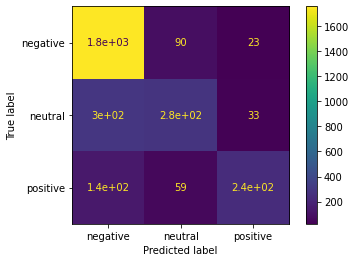

In [29]:
plot_confusion_matrix(model_lg, X_test, y_test)  
# plt.show() 

In [30]:
print('Classificaation Report is:')
print(classification_report(y_test,y_pred_lg))

Classificaation Report is:
              precision    recall  f1-score   support

    negative       0.80      0.94      0.86      1870
     neutral       0.66      0.46      0.54       614
    positive       0.81      0.55      0.65       444

    accuracy                           0.78      2928
   macro avg       0.76      0.65      0.69      2928
weighted avg       0.77      0.78      0.76      2928



In [31]:
print('Accuracy on the test set is:')
print(accuracy_score(y_test, y_pred_lg))

Accuracy on the test set is:
0.7800546448087432


- The logistic regression performs better , but im not sure if since this is a 3 class prediction if this is the right approach , i beileve that the Naive Bayes classifier model is a better fit for such data sets

# Part 3

### The top 3 airlines in terms of the fraction of negative tweets

In [32]:
airline_array=df['airline'].unique()
dict_neg={}
for airline in airline_array:
  df_1=df[df['airline']==airline]
  count=df_1['airline_sentiment'].count()
  count=df_1['text'].count()
  d=df_1[df_1['airline_sentiment']=='negative']
  neg=d['text'].count()
  a=neg/count
  dict_neg[airline]=a
negative=pd.DataFrame.from_dict(dict_neg,orient='index', columns=['Fraction of negative Tweets'])
print('The top 3 airlines in terms of the fraction of negative tweets')
negative.sort_values(by='Fraction of negative Tweets',ascending=False).head(3)

The top 3 airlines in terms of the fraction of negative tweets


,Fraction of negative Tweets
US Airways,0.776862
American,0.710402
United,0.688906


In [33]:
print('The top 3 airlines in terms of the fraction of negative tweets')
print(negative.sort_values(by='Fraction of negative Tweets',ascending=False).head(3).index.values)

The top 3 airlines in terms of the fraction of negative tweets
['US Airways' 'American' 'United']


### The top 3 airlines in terms of the fraction of positive tweets

In [34]:
airline_array=df['airline'].unique()
dict_pos={}
for airline in airline_array:
  df_1=df[df['airline']==airline]
  count=df_1['airline_sentiment'].count()
  count=df_1['text'].count()
  d=df_1[df_1['airline_sentiment']=='positive']
  neg=d['text'].count()
  a=neg/count
  dict_pos[airline]=a
positive=pd.DataFrame.from_dict(dict_pos,orient='index', columns=['Fraction of positive Tweets'])
print('The top 3 airlines in terms of the fraction of positive tweets')
positive.sort_values(by='Fraction of positive Tweets',ascending=False).head(3)

The top 3 airlines in terms of the fraction of positive tweets


,Fraction of positive Tweets
Virgin America,0.301587
Delta,0.244824
Southwest,0.235537


In [35]:
print('The top 3 airlines in terms of the fraction of positive tweets')
print(positive.sort_values(by='Fraction of positive Tweets',ascending=False).head(3).index.values)

The top 3 airlines in terms of the fraction of positive tweets
['Virgin America' 'Delta' 'Southwest']
